In [1]:
from pystan import StanModel
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
models = pickle.load(open('model.pkl', 'rb'))

In [3]:
def test_model_inference(model_name, Y=None, generated_data='data_latent', models=models, 
                         generator_iter=50, inference_iter=1000):
    
    if Y is None:
        Y = pd.DataFrame(rand(100,5))
    stan_data = {**models[model_name]['stan_data_creator'](Y, run_inference=False), 
                 **models[model_name]['parameter_priors']} 

    generated_example = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=generator_iter)

    sample = 20
    generated_parameters = {}
    for parameter in models[model_name]['model_parameters']:
        generated_parameters[parameter] = generated_example[parameter][sample]

    generated_data = pd.DataFrame(generated_example[generated_data][sample])

    stan_data = {**models[model_name]['stan_data_creator'](generated_data, run_inference=True), 
                 **models[model_name]['parameter_priors']} 
    model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=inference_iter)

    true_parameters_inferred_scores = {}
    true_parameters_inferred_score_within_95CI = 0
    n_parameters = 0
    from scipy.stats import percentileofscore
    
    for parameter in models[model_name]['model_parameters']:
        parameter_samples = model_fit[parameter]
        if parameter_samples.ndim>2:
            parameter_samples = parameter_samples.reshape(parameter_samples.shape[0], 
                                                          prod(parameter_samples.shape[1:]))
        true_parameters_inferred_scores[parameter] = array(list(map(percentileofscore, 
                                                             parameter_samples.T, 
                                                             generated_parameters[parameter].ravel())))
        true_parameters_inferred_score_within_95CI += sum((true_parameters_inferred_scores[parameter]>2.5) & 
                                                          (true_parameters_inferred_scores[parameter]<97.5)
                                                         )
        n_parameters += true_parameters_inferred_scores[parameter].size
    return true_parameters_inferred_score_within_95CI/n_parameters#, true_parameters_inferred_score_within_95CI

from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer

def plot_time_series_inference(model_fit, var='data_latent', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)

In [39]:
model_name = 'price~SVAR'
models[model_name] = {}

models[model_name]['code'] = """
data {
  int T; // The number of time periods
  int L; // the number of lags
  int K; // the number of variables
  int S; // number of periods for IRFs
  vector[K] dat[T]; // the time series, rows are time periods, columns are variables
  
  //priors' distributions' parameters
  
  real alpha_location;
  real alpha_scale;
  real beta_location;
  real beta_scale;
  real beta_intercept_location;
  real beta_intercept_scale;
  
  real tau_scale;
}

transformed data {
  vector[L*K] x[T-L]; // the lagged variable vector 
  // now fill in the X vector with lagged variables
  for(t in 1:(T-L)) {
    {
    int count;
    count = 0;
    for(l in 1:L) {
      for(k in 1:K) {
        count = count + 1;
        x[t][count] = dat[t+L-l][k];
      }
    }
  }
  
  // the output of this weird triple for loop is a set of vectors whose first element is 1 (the intercept)
  // the rest of the values are lagged dependent values
  }
}

parameters {
  vector[K*K-K] alpha_parameters;
  
  vector[K] beta_intercept;
  matrix[K,K*L] beta; // the LR matrix (ex. constant)
  vector<lower = 0>[K] tau; // the standard deviation of the structural shocks
}

transformed parameters {
  matrix[K,K] alpha; // the impact matrix
  
  matrix[K*L,K*L] fcomp; // the companion matrix
  matrix[K, K*L] beta_reduced_form;
  
  for(i in 1:K) {
    alpha[i, i] = 1;
  }
  
  for(i in 1:K){
      for(j in 1:K){
          if(i==j){
              alpha[i,j] = 1;
          } else {
              alpha[i,j] = alpha_parameters[(i-1)*K+j];
          }
      }
  }
  
  beta_reduced_form = inverse(alpha)*beta;

  #Comapanion Matrix Defined Here ( VAR(p) written as VAR(1) ) 
  for(i in 1:(K*L)) {
    for(j in 1:(K*L)) {  
      if(i<=K) {
        fcomp[i,j] = beta_reduced_form[i,j];
      } else if(j==(i-K)) {
          fcomp[i,j] = 1;
        } else {
          fcomp[i,j] = 0; 
        } 
    }
  }
}

model {
  // Priors on beta
  for(k1 in 1:K) {
    for(k2 in 1:(K*L)) {
        beta[k1, k2] ~ normal(beta_location, beta_scale);

      //if(k1==k2) {
        // priors on the AR1 terms
      //  beta[k1, k2] ~ normal(1, 0.2);
      //} else {
        // priors on the rest
      //  beta[k1, k2] ~ normal(0, 0.3);
      //}
    }
  }

  // Priors on tau
  // because tau is defined as being non-negative, this is a half-cauchy prior
  tau ~ cauchy(0, tau_scale);

  // Normal 0,1 priors on the alpha parameters
  for(i in 1:K) {
    for (j in 1:K) {
      if(i!=j) {
        target += normal_lpdf(alpha[i,j] | alpha_location, alpha_scale);
      }
    }
  }

  target += normal_lpdf(beta_intercept| beta_intercept_location, beta_intercept_scale);
  
  # The data model
  for(t in 1:(T-L)){
    target +=normal_lpdf(alpha*dat[t+L] - beta_intercept - beta*x[t] | 0, tau);
  }
}

generated quantities {
  // Impulse Responses
  // IR[s] = Fcomp^(s-1) * inverse(A)*shock
  matrix[S,K*K] y_sim; //stored impulse responses
  vector[K] shock;  //impulse vector (pick shock)
  vector[K*L] shock_big; //impulse vector (reshaped to be compatible with for fcomp)
  matrix[K*L,K*L] fcomp_eye; //fcomp multiplier (to raise matrix to power of s)
  int irfcount;

  // fill in shock and shock_big with 0
  shock = rep_vector(0.0, K);
  shock_big = rep_vector(0.0, K*L);
  fcomp_eye = diag_matrix(rep_vector(1.0, K*L));
      
  for(k in 1:K) {
    matrix[K*L, K*L] fcomp_eye2;
    fcomp_eye2 = fcomp_eye;
    
    shock[k]=1;
    irfcount=(k-1)*K;
    shock_big[1:K]=inverse(alpha)*shock;
  
    for(s in 1:S) {	
      if(s==1) {
        y_sim[s,(1+irfcount):(K+irfcount)] = to_row_vector(inverse(alpha)*shock);
      } else {
        fcomp_eye2=fcomp_eye2*fcomp;
        y_sim[s,(1+irfcount):(K+irfcount)] = to_row_vector((fcomp_eye2*shock_big)[1:K]);
      }
    }
    shock[k]=0;
    shock_big[1:K] = rep_vector(0.0, K);
  }
}

"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'alpha_location': 0,
    'alpha_scale': 1,
    'beta_location': 0,
    'beta_scale': 1,
    'beta_intercept_location': 0,
    'beta_intercept_scale': 1,
    'tau_scale': .5,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dae8b1f7dcc7d3cbd0d5d65b5c1b0853 NOW.


In [15]:
model_name = 'price~VAR, hierachical'
models[model_name] = {}

models[model_name]['code'] = """

data {
  int N; // number of observations (number of rows in the panel)
  int K; // number of dimensions of the outcome variable
  int I; // number of individuals
  int T; // The greatest number of time periods for any individual
  int<lower = 1, upper = I> individual[N]; // integer vector the same length 
  // as the panel, indicating which individual each row corresponds to
  int<lower = 1, upper = T> time[N]; // integer vector with individual-time 
  // (not absolute time). Each individual starts at 1
  matrix[N, K] Y; // the outcome matrix, each individual stacked on each 
  // other, observations ordered earliest to latest
  
  // priors' distributions' parameters
  real rho_1;
  real rho_2;
  real tau_location_location;
  real tau_location_scale;
  real tau_scale_location;
  real tau_scale_scale;
  real alpha_hat_location_location;
  real alpha_hat_location_scale;
  real alpha_hat_scale_location;
  real alpha_hat_scale_scale;
  real alpha_scale_location;
  real alpha_scale_scale;
  
  real beta_hat_location_location;
  real beta_hat_location_scale;
  real beta_hat_scale_location;
  real beta_hat_scale_scale;
  
  real Omega_global_eta;
  real Omega_local_eta;
}
parameters {
  // individual-level parameters
  corr_matrix[K] Omega_local[I]; // cholesky factor of correlation matrix of 
  // residuals each individual (across K outcomes)
  vector<lower = 0>[K] tau[I]; // scale vector for residuals
  matrix[K, K] z_beta[I];
  vector[K] z_alpha[I];
  
  // hierarchical priors (individual parameters distributed around these)
  real<lower = 0, upper = 1> rho;
  corr_matrix[K] Omega_global;
  vector[K] tau_location;
  vector<lower =0>[K] tau_scale;
  matrix[K,K] beta_hat_location;
  matrix<lower = 0>[K,K] beta_hat_scale;
  vector[K] alpha_hat_location;
  vector<lower = 0>[K] alpha_hat_scale;
}
transformed parameters {
  matrix[K, K] beta[I]; // VAR(1) coefficient matrix
  vector[K] alpha[I]; // intercept matrix
  corr_matrix[K] Omega[I];
  
  for(i in 1:I) {
    alpha[i] = alpha_hat_location + alpha_hat_scale .*z_alpha[i];
    beta[i] = beta_hat_location + beta_hat_scale .*z_beta[i];
    Omega[i] = rho*Omega_global + (1-rho)*Omega_local[i];
  }
    
}
model {
  // hyperpriors
  rho ~ beta(rho_1, rho_2);
  tau_location ~ cauchy(tau_location_location, tau_location_scale);
  tau_scale ~ cauchy(tau_scale_location, tau_scale_scale);
  alpha_hat_location ~ normal(alpha_hat_location_location, alpha_hat_location_scale);
  alpha_hat_scale ~ cauchy(alpha_hat_scale_location, alpha_hat_scale_scale);
  to_vector(beta_hat_location) ~ normal(beta_hat_location_location, beta_hat_location_scale);
  to_vector(beta_hat_scale) ~ cauchy(beta_hat_scale_location, beta_hat_scale_scale);
  Omega_global ~ lkj_corr(Omega_global_eta);

  
  // hierarchical priors
  for(i in 1:I) {
    // non-centered parameterization
    z_alpha[i] ~ normal(0, 1);
    to_vector(z_beta[i]) ~ normal(0, 1);
    tau[i] ~ normal(tau_location, tau_scale);
    Omega_local[i] ~ lkj_corr(Omega_local_eta);
  }
  
  // likelihood
  for(n in 1:N) {
    if(time[n]>1) {
      Y[n] ~ multi_normal(alpha[individual[n]] + beta[individual[n]]*Y[n-1]', 
                          quad_form_diag(Omega[individual[n]], tau[individual[n]]));
    }
  }
}
"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'rho_1': 2,
    'rho_2': 2,
    'tau_location_location': 0,
    'tau_location_scale': 1,
    'tau_scale_location': 0,
    'tau_scale_scale': 1,
    'alpha_hat_location_location': 0,
    'alpha_hat_location_scale': 1,
    'alpha_hat_scale_location': 0,
    'alpha_hat_scale_scale': 1,
    'beta_hat_location_location': 0,
    'beta_hat_location_scale': .5,
    'beta_hat_scale_location': 0,
    'beta_hat_scale_scale': .5,
    'Omega_global_eta': 1,
    'Omega_local_eta': 10,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc2b7420108db6abd43df1f57f1e35aa NOW.


In [63]:
model_name = 'price~VAR'
models[model_name] = {}

models[model_name]['code'] = """
data {
  int T; // The number of time periods
  int L; // the number of lags
  int K; // the number of variables
  vector[K] dat[T]; // the time series, rows are time periods, columns are variables
  
  //priors' distributions' parameters

  real beta_location;
  real beta_scale;
  real beta_intercept_location;
  real beta_intercept_scale;
  
  real tau_scale;
}

transformed data {
  vector[L*K] x[T-L]; // the lagged variable vector 
  // now fill in the X vector with lagged variables
  for(t in 1:(T-L)) {
    {
    int count;
    count = 0;
    for(l in 1:L) {
      for(k in 1:K) {
        count = count + 1;
        x[t][count] = dat[t+L-l][k];
      }
    }
  }
  
  // the output of this weird triple for loop is a set of vectors whose values are lagged dependent values
  }
}

parameters {  
  vector[K] beta_intercept;
  matrix[K,K*L] beta; // the LR matrix (ex. constant)
  vector<lower = 0>[K] tau; // the standard deviation of the structural shocks
}


model {
  // Priors on beta
  for(k1 in 1:K) {
    for(k2 in 1:(K*L)) {
        beta[k1, k2] ~ normal(beta_location, beta_scale);
    }
  }
  beta_intercept ~ normal(beta_intercept_location, beta_intercept_scale);
  
  // because tau is defined as being non-negative, this is a half-cauchy prior
  tau ~ cauchy(0, tau_scale);
  
  # The data model
  for(t in 1:(T-L)){
    target +=normal_lpdf(dat[t+L] - beta_intercept - beta*x[t] | 0, tau);
  }
}


"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'beta_location': 0,
    'beta_scale': 1,
    'beta_intercept_location': 0,
    'beta_intercept_scale': 1,
    'tau_scale': .5,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y,L=3):
    stan_data = {'dat':Y,
                 'T': Y.shape[0],
                 'K': Y.shape[1],
                 'L': L,
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70c5bc315e3acd011294d0542382cebb NOW.


In [162]:
model_name = 'price~VAR, missing data'
models[model_name] = {}

models[model_name]['code'] = """
data {
  int T; // The number of time periods
  int L; // the number of lags
  int K; // the number of variables
  vector[K] dat[T]; // the time series, rows are time periods, columns are variables
  
  //priors' distributions' parameters

  real beta_location;
  real beta_scale;
  real beta_intercept_location;
  real beta_intercept_scale;
  
  real tau_scale;
}


parameters {  
  vector[K] beta_intercept;
  matrix[K,K*L] beta; // the LR matrix (ex. constant)
  vector<lower = 0>[K] tau; // the standard deviation of the structural shocks
  vector[K] data_latent[T]; // the time series, rows are time periods, columns are variables
}

transformed parameters {
  vector[L*K] x[T-L]; // the lagged variable vector 
  // now fill in the X vector with lagged variables
  for(t in 1:(T-L)) {
    {
    int count;
    count = 0;
    for(l in 1:L) {
      for(k in 1:K) {
        count = count + 1;
        x[t][count] = data_latent[t+L-l][k];
      }
    }
  }
  // the output of this weird triple for loop is a set of vectors whose first element is 1 (the intercept)
  // the rest of the values are lagged dependent values
  }    
}


model {
  // Priors on beta
  for(k1 in 1:K) {
    for(k2 in 1:(K*L)) {
        beta[k1, k2] ~ normal(beta_location, beta_scale);
    }
  }
  beta_intercept ~ normal(beta_intercept_location, beta_intercept_scale);
  
  // because tau is defined as being non-negative, this is a half-cauchy prior
  tau ~ cauchy(0, tau_scale);
  
  # The latent data model
  for(t in 1:(T-L)){
    target +=normal_lpdf(data_latent[t+L] - beta_intercept - beta*x[t] | 0, tau);
  }
  
  # The measurement model
  for (k in 1:K){
      for(t in 1:T){
      if (dat[t,k]>-999) {
          dat[t,k] ~ normal(data_latent[t,k], 0.1);
      }
      }
  }
}


"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'beta_location': 0,
    'beta_scale': 1,
    'beta_intercept_location': 0,
    'beta_intercept_scale': 1,
    'tau_scale': .5,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y,L=3):
    stan_data = {'dat':Y,
                 'T': Y.shape[0],
                 'K': Y.shape[1],
                 'L': L,
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d448e6688be63efb43b2ea3d21511cf NOW.


In [16]:
model_name = 'Y_change~VAR, missing data'
models[model_name] = {}

models[model_name]['code'] = """
data {
  int T; // The number of time periods
  int L; // the number of lags
  int K; // the number of variables
  vector[K] dat[T]; // the time series, rows are time periods, columns are variables
  
  //priors' distributions' parameters

  real beta_location;
  real beta_scale;
  real beta_intercept_location;
  real beta_intercept_scale;
  
  real tau_scale;
  
  int run_inference;
}


parameters {  
  vector[K] beta_intercept;
  matrix[K,K*L] beta; // the LR matrix (ex. constant)
  vector<lower = 0>[K] tau; // the standard deviation of the structural shocks
  vector[K] data_latent[T]; // the time series, rows are time periods, columns are variables
}

transformed parameters {
  vector[K] data_latent_change[T-1];
  vector[L*K] x[T-L-1]; // the lagged variable vector 
  
  for (t in 1:T-1){
    data_latent_change[t] = data_latent[t+1]-data_latent[t];
  }
  
  // now fill in the X vector with lagged variables
  for(t in 1:(T-L-1)) {
    {
    int count;
    count = 0;
    for(l in 1:L) {
      for(k in 1:K) {
        count = count + 1;
        x[t][count] = data_latent_change[t+L-l][k];
      }
    }
  }
  // the output of this weird triple for loop is a set of vectors whose values are lagged dependent values
  }    
}


model {
  // Priors on beta
  for(k1 in 1:K) {
    for(k2 in 1:(K*L)) {
        beta[k1, k2] ~ normal(beta_location, beta_scale);
    }
  }
  beta_intercept ~ normal(beta_intercept_location, beta_intercept_scale);
  
  // because tau is defined as being non-negative, this is a half-cauchy prior
  tau ~ cauchy(0, tau_scale);
  
  # The latent data model
  for(t in 1:(T-L-1)){
    target +=normal_lpdf(data_latent_change[t+L] - beta_intercept - beta*x[t] | 0, tau);
  }
  
  # The measurement model, where we actually connect up to data
  if (run_inference==1){
      for (k in 1:K){
          for(t in 1:T){
          if (dat[t,k]>-999) {
              dat[t,k] ~ normal(data_latent[t,k], 0.1);
          }
          }
      }
  }
}


"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'beta_location': 0,
    'beta_scale': 1,
    'beta_intercept_location': 0,
    'beta_intercept_scale': 1,
    'tau_scale': .5,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y,L=3,run_inference=True):
    stan_data = {'dat':Y.fillna(-999),
                 'T': Y.shape[0],
                 'K': Y.shape[1],
                 'L': L,
                 'run_inference': run_inference,
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

# print(model_name)
# print("Portion of parameters' true values within the 95%% CI: %.3f"%(test_model_inference(model_name)))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3fae0b13d782a4dd460d2cdafed8f6d NOW.


In [6]:
model_name = 'Y_change~VAR, missing data, Vehtari horseshoe prior'
models[model_name] = {}

models[model_name]['code'] = """
data {
  int T; // The number of time periods
  int L; // the number of lags
  int K; // the number of variables
  vector[K] dat[T]; // the time series, rows are time periods, columns are variables
  
  //priors' distributions' parameters
  real expected_nonzero_betas; //prior guess for the number of nonzero coefficients per variable
  
  real beta_intercept_location;
  real beta_intercept_scale;  
  real sigma_scale;
  
  int run_inference;
}


parameters {  
  matrix[K,K*L] beta; // the LR matrix (ex. constant)
  matrix<lower = 0>[K,K*L] lambda; //horseshoe prior local shrinkage scales
  
  vector[K] beta_intercept;
  vector<lower = 0>[K] sigma; // scale of the errors

  vector[K] data_latent[T]; // the latent time series, rows are time periods, columns are variables
}

transformed parameters {
  vector[K] data_latent_change[T-1];
  vector[L*K] x[T-L-1]; // the lagged variable vector 
  vector<lower = 0>[K] tau; // horseshoe prior global shrinkage
  
  for (t in 1:T-1){
    data_latent_change[t] = data_latent[t+1]-data_latent[t];
  }
  
  // now fill in the X vector with lagged variables
  for(t in 1:(T-L-1)) {
    {
    int count;
    count = 0;
    for(l in 1:L) {
      for(k in 1:K) {
        count = count + 1;
        x[t][count] = data_latent_change[t+L-l][k];
      }
    }
  }
  // the output of this weird triple for loop is a set of vectors whose values are lagged dependent values
  }
  
  // Define the horseshoe prior global shrinkage term based on the expected nonzero betas per variable
  tau = (expected_nonzero_betas/(K*L-expected_nonzero_betas)) * (sigma/sqrt(T-1));  
}


model {
  // Priors on beta
  for(k1 in 1:K) {
    for(k2 in 1:(K*L)) {
        lambda[k1,k2] ~ cauchy(0, 1);
        beta[k1, k2] ~ normal(0, lambda[k1,k2]*tau[k1]);
    }
  }
  
  beta_intercept ~ normal(beta_intercept_location, beta_intercept_scale);
  sigma ~ cauchy(0, sigma_scale);
  
  # The latent data model
  for(t in 1:(T-L-1)){
    target +=normal_lpdf(data_latent_change[t+L] - beta_intercept - beta*x[t] | 0, sigma);
  }
  
  # The measurement model, where we actually connect up to data
  if (run_inference==1){
      for (k in 1:K){
          for(t in 1:T){
          if (dat[t,k]>-999) {
              dat[t,k] ~ normal(data_latent[t,k], 0.1);
          }
          }
      }
  }
}


"""
models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'beta_intercept_location': 0,
    'beta_intercept_scale': 1,
    'sigma_scale': .5,
    }

models[model_name]['model_parameters'] = unique([i.rsplit('_', 1)[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y,L=3,expected_nonzero_betas=None,run_inference=True):
    if expected_nonzero_betas is None:
        expected_nonzero_betas = L+round(.01*Y.shape[1])
    stan_data = {'dat':Y.fillna(-999),
                 'T': Y.shape[0],
                 'K': Y.shape[1],
                 'L': L,
                 'expected_nonzero_betas': expected_nonzero_betas,
                 'run_inference': int(run_inference),
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

# print(model_name)
# print("Portion of parameters' true values within the 95%% CI: %.3f"%(test_model_inference(model_name)))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d5ebbf68d2655bdeddc6dc986560e45 NOW.


In [32]:
data_directory = '../data/'

empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.loc[(metadata['Source']=='Farmer_Lafond')*(metadata['Type']=='Price'), 'Name']
empirical_time_series = log(empirical_data[target_tech_names])

# valid_time_series = sum(~empirical_time_series.loc[1976:].isnull())>3
# valid_domains = metadata.set_index('Name').loc[valid_time_series.index[valid_time_series]]['Domain'].unique()

# print("Number of valid domains: %i"%valid_domains.size)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [42]:
%%time
Y = empirical_time_series.loc[1920:]
any_data = Y.isnull().all(axis=0)
Y = Y[any_data[~any_data].index].iloc[:,[0,1,2,3,4,5,27]]

model_name = 'Y_change~VAR, missing data, Vehtari horseshoe prior'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

CPU times: user 186 ms, sys: 106 ms, total: 292 ms
Wall time: 3min 28s


In [44]:
sum(list(map(prod, model_fit.par_dims)))

3514

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


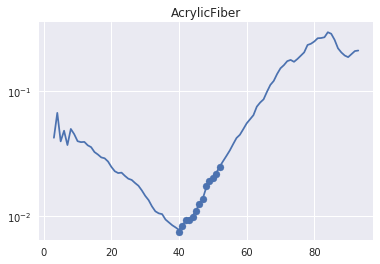

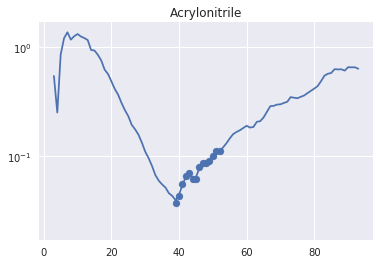

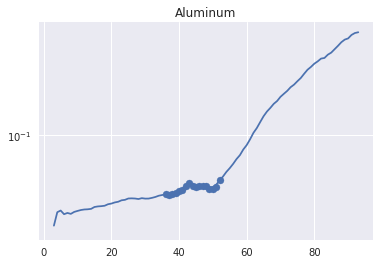

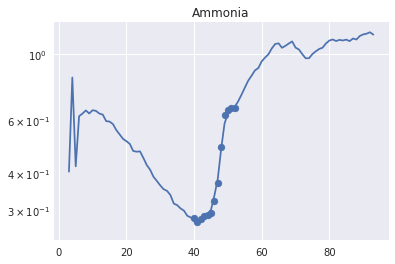

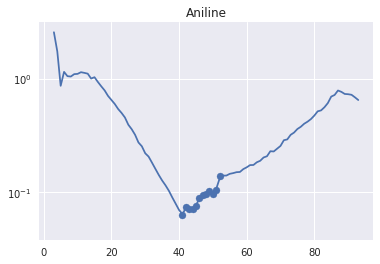

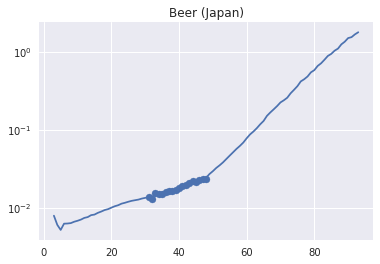

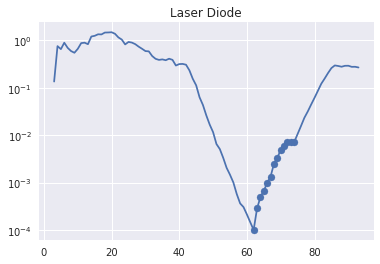

In [43]:
### With horseshoe
q = median(model_fit['data_latent'], axis=0)
L = stan_data['L']
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(arange(L, Y.shape[0]), exp(q[L:,i]))
    title(Y.columns[i])
    yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


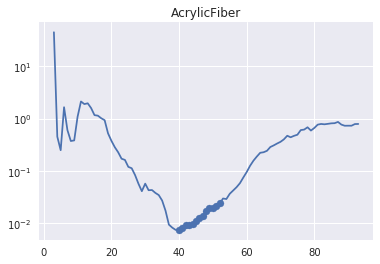

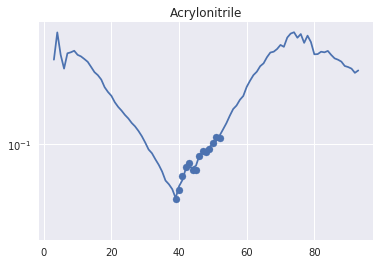

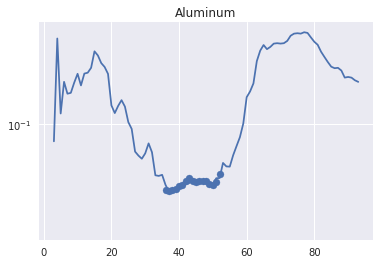

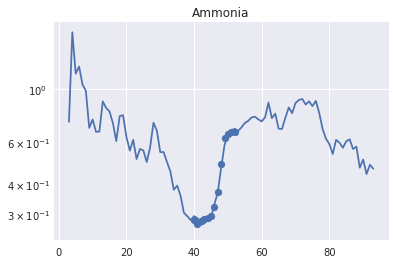

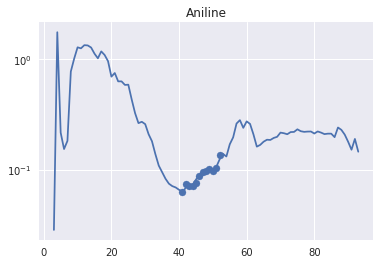

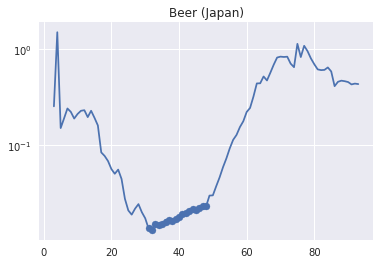

In [38]:
### With horseshoe
q = median(model_fit['data_latent'], axis=0)
L = stan_data['L']
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(arange(L, Y.shape[0]), exp(q[L:,i]))
    title(Y.columns[i])
    yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


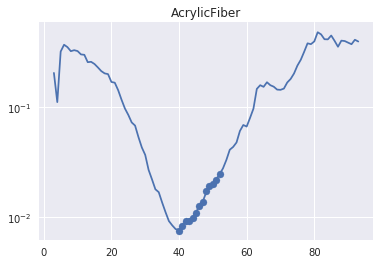

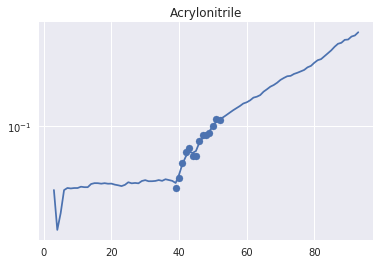

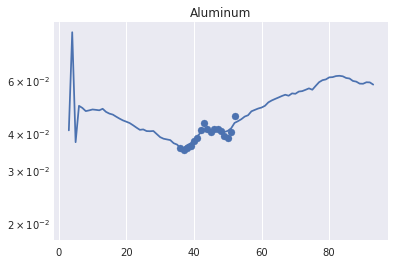

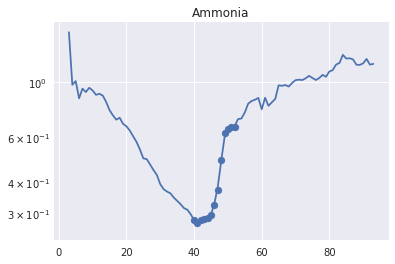

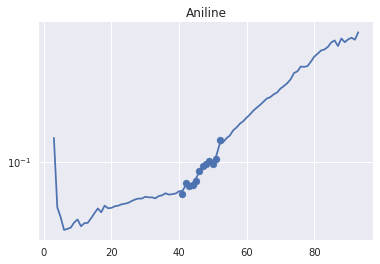

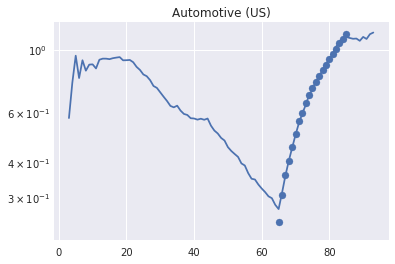

In [27]:
### With horseshoe
q = median(model_fit['data_latent'], axis=0)
L = stan_data['L']
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(arange(L, Y.shape[0]), exp(q[L:,i]))
    title(Y.columns[i])
    yscale('log')

In [14]:
model_fit_horseshoe = model_fit

In [15]:
%%time
Y = empirical_time_series.loc[1920:]
any_data = Y.isnull().all(axis=0)
Y = Y[any_data[~any_data].index].iloc[:,:5]

model_name = 'Y_change~VAR, missing data'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

### With horseshoe
q = median(model_fit['data_latent'], axis=0)
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(exp(q[:,i]))
    title(Y.columns[i])
    yscale('log')

KeyError: 'Y_change~VAR, missing data'

In [62]:
%%time
Y = empirical_time_series.loc[1960:1972].dropna(axis=1).diff().iloc[1:]

model_name = 'price~VAR'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

CPU times: user 143 ms, sys: 77 ms, total: 220 ms
Wall time: 2min 48s


In [164]:
%%time
Y = empirical_time_series.loc[1960:1972].dropna(axis=1).diff().iloc[1:]


model_name = 'price~VAR, missing data'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=50)

CPU times: user 224 ms, sys: 117 ms, total: 341 ms
Wall time: 12.5 s


In [146]:
%%time
Y = empirical_time_series.loc[1920:].diff()
any_data = Y.isnull().all(axis=0)
Y[any_data[~any_data].index]

model_name = 'price~VAR, missing data'
stan_data = {**models[model_name]['stan_data_creator'](Y,L=5), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

CPU times: user 1min 4s, sys: 14.8 s, total: 1min 19s
Wall time: 16h 31min 56s


In [292]:
%%time
Y = empirical_time_series.loc[1920:]
any_data = Y.isnull().all(axis=0)
Y = Y[any_data[~any_data].index]

model_name = 'Y_change~VAR, missing data'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=50)

CPU times: user 790 ms, sys: 216 ms, total: 1.01 s
Wall time: 1min 53s


In [ ]:
%%time
Y = empirical_time_series.loc[1920:]
any_data = Y.isnull().all(axis=0)
Y = Y[any_data[~any_data].index]

model_name = 'Y_change~VAR, missing data, Vehtari horseshoe prior'
stan_data = {**models[model_name]['stan_data_creator'](Y), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

In [339]:
sum(list(map(prod, model_fit.par_dims)))

55250

In [333]:
q = median(model_fit['data_latent'], axis=0)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


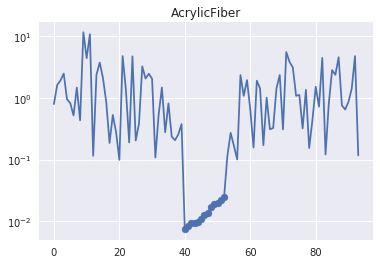

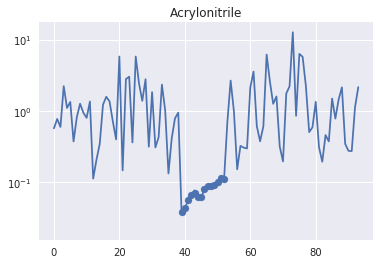

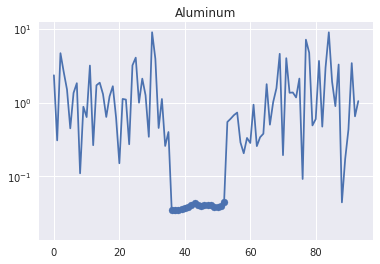

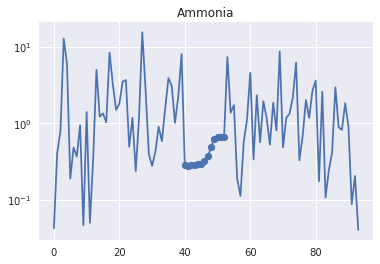

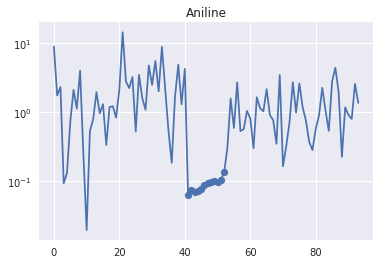

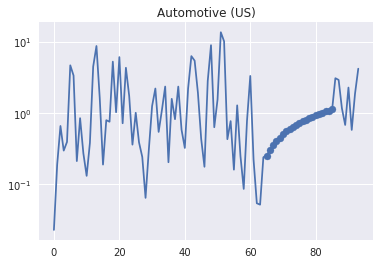

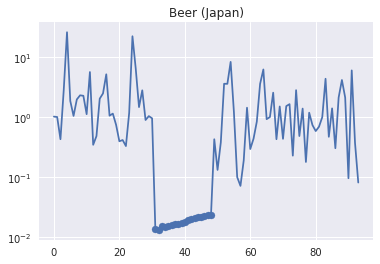

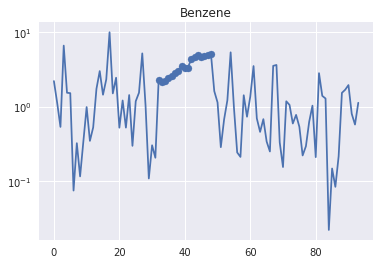

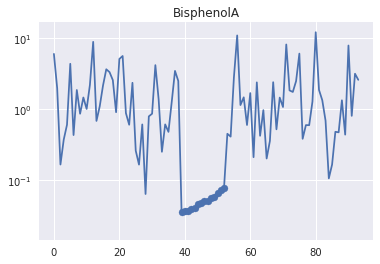

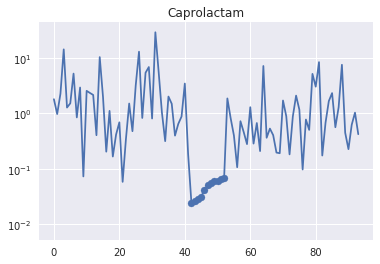

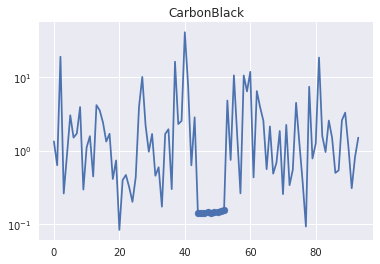

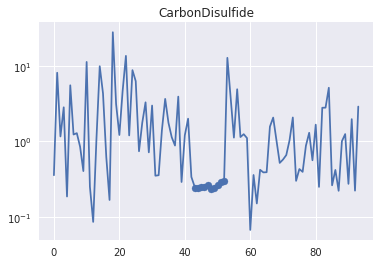

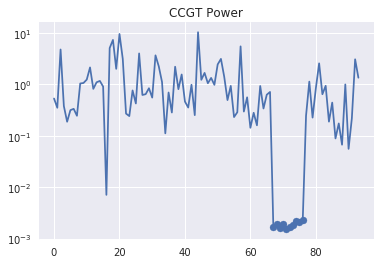

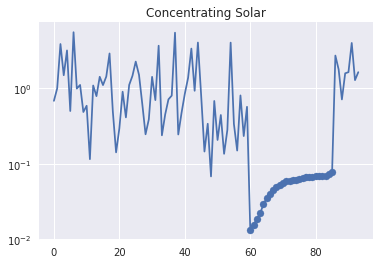

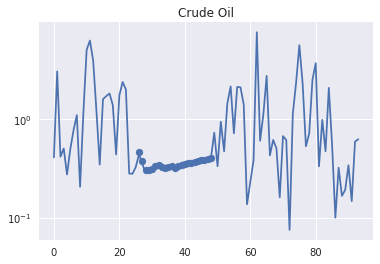

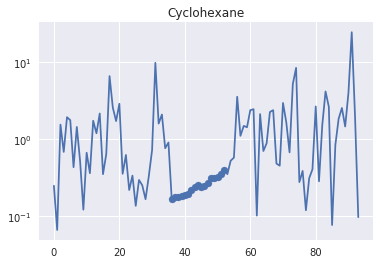

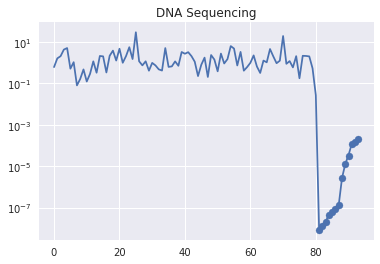

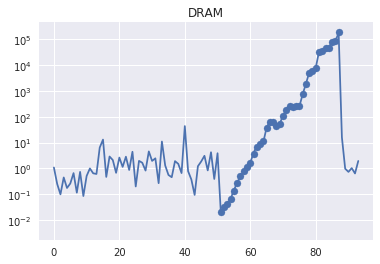

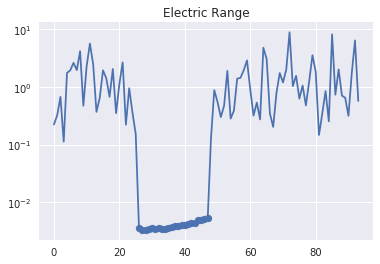

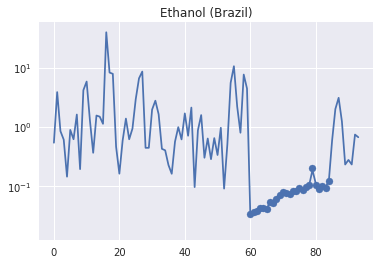

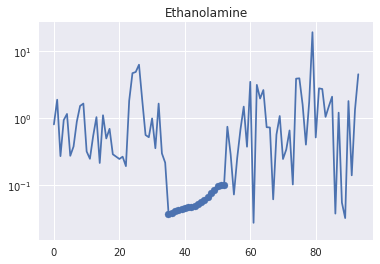

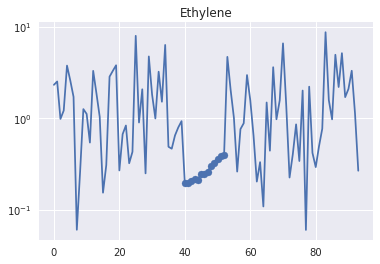

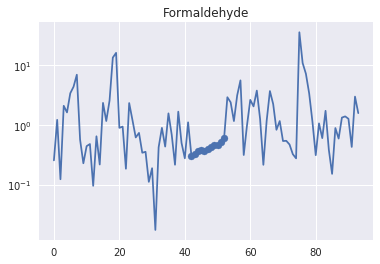

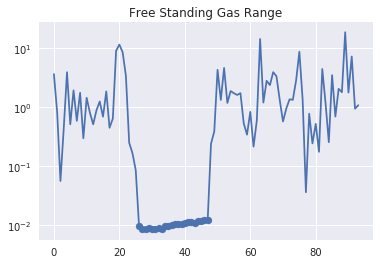

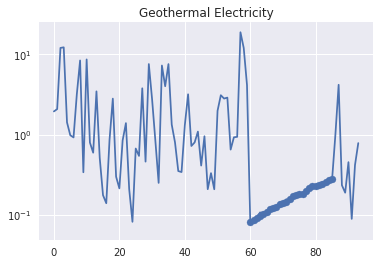

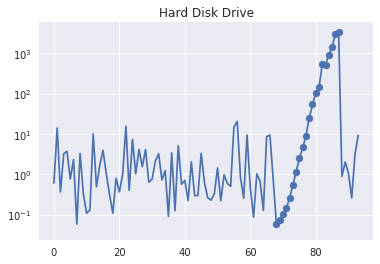

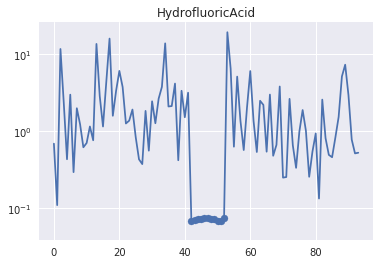

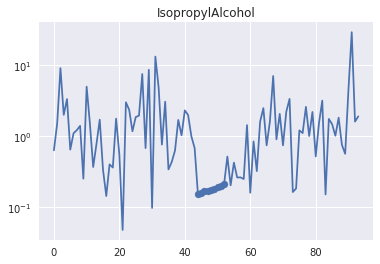

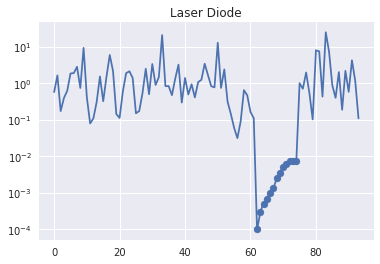

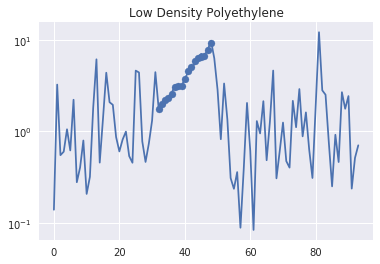

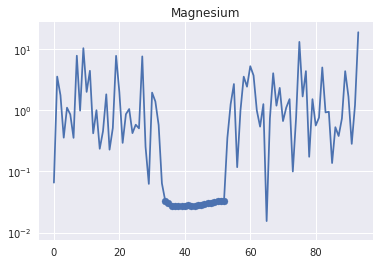

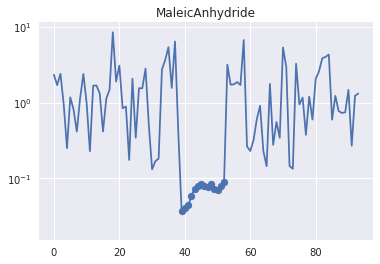

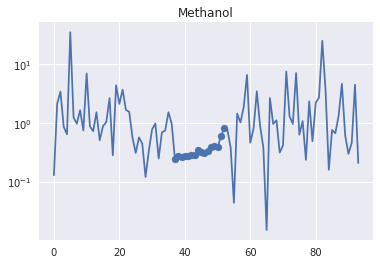

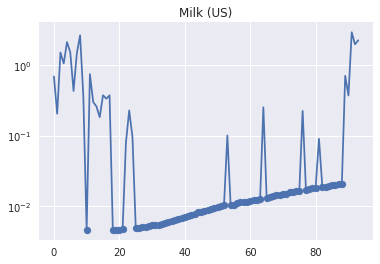

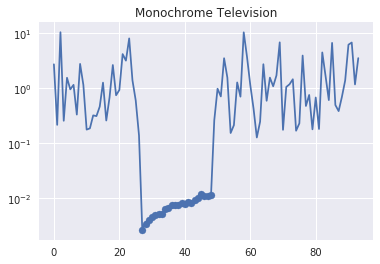

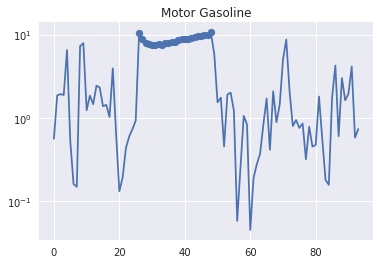

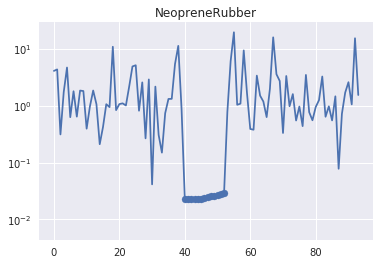

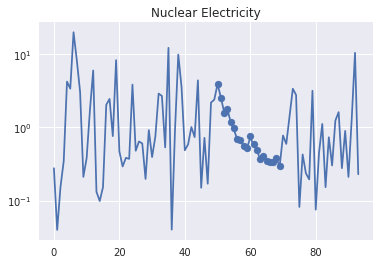

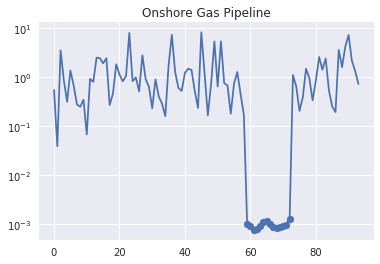

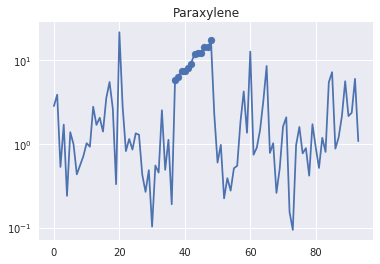

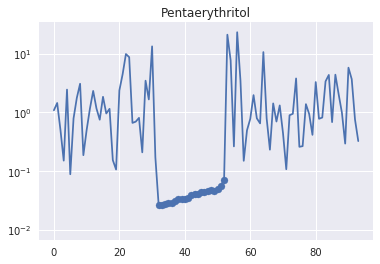

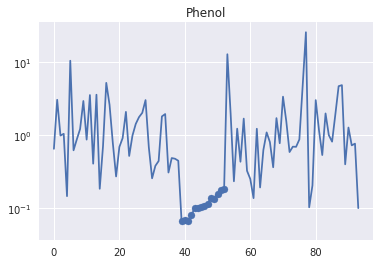

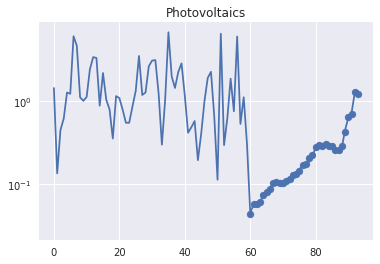

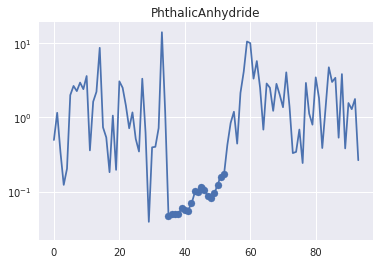

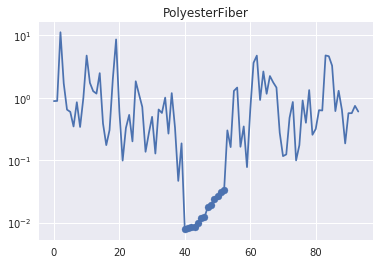

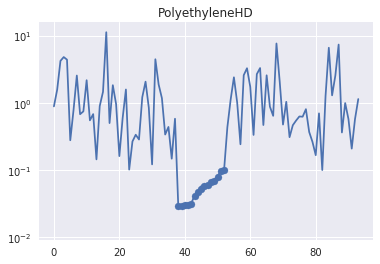

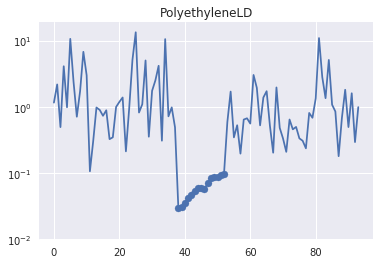

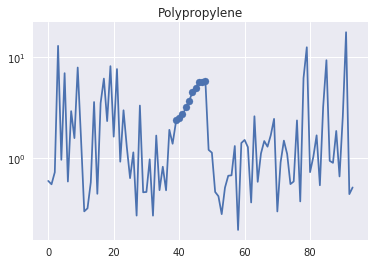

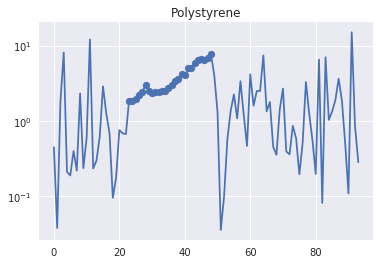

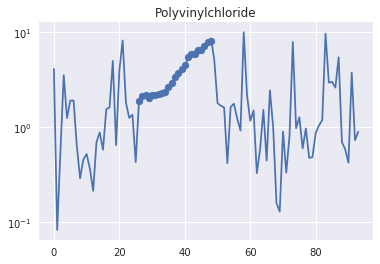

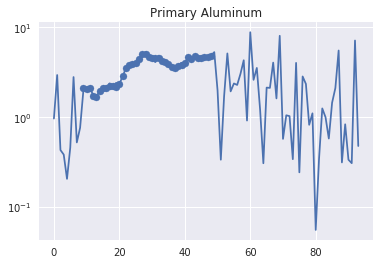

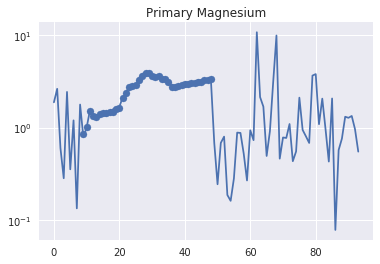

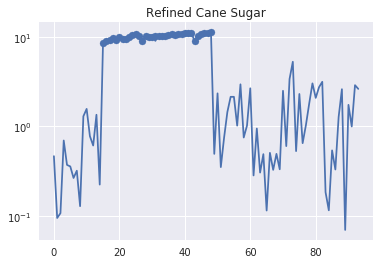

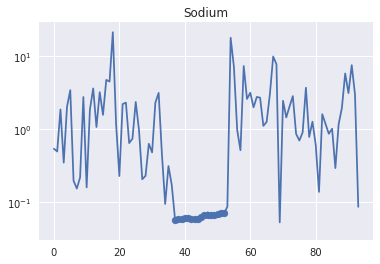

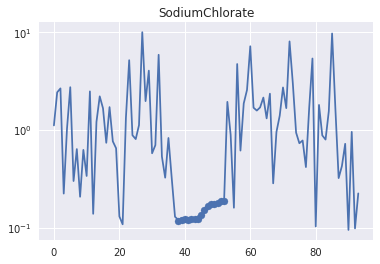

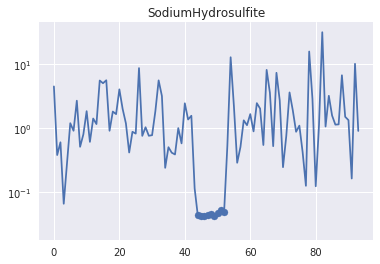

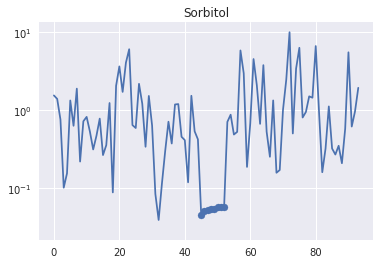

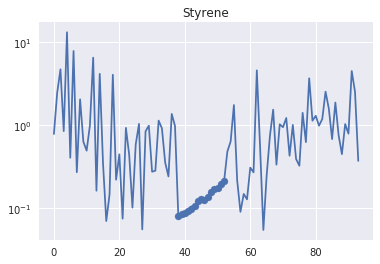

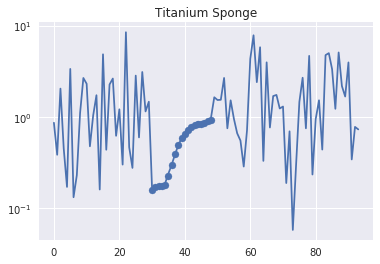

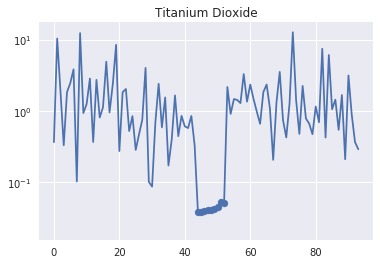

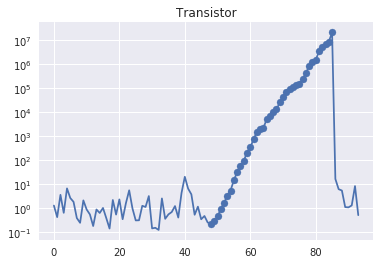

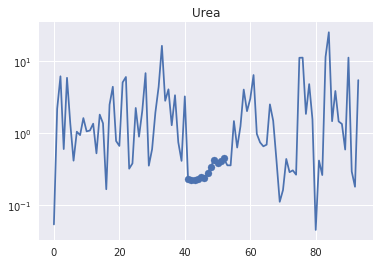

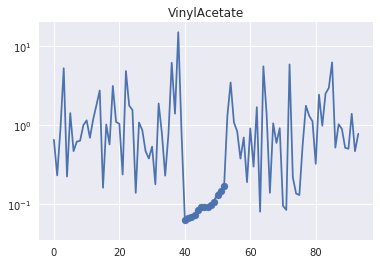

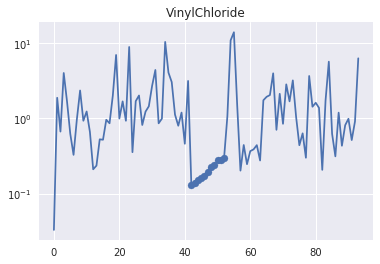

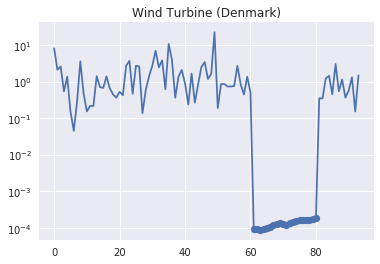

In [334]:
### With horseshoe
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(exp(q[:,i]))
    title(Y.columns[i])
    yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


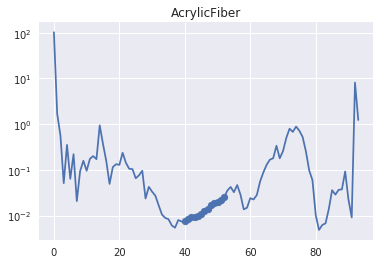

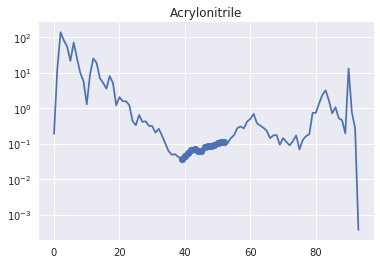

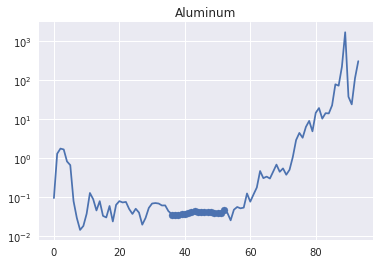

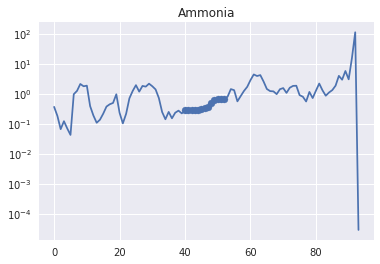

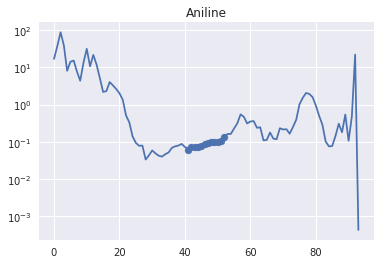

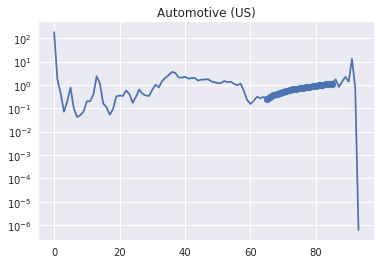

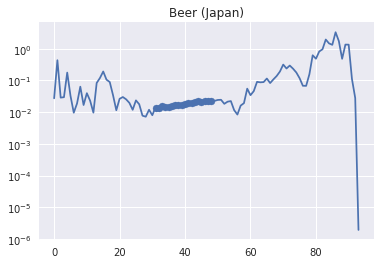

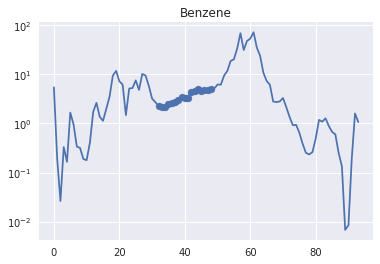

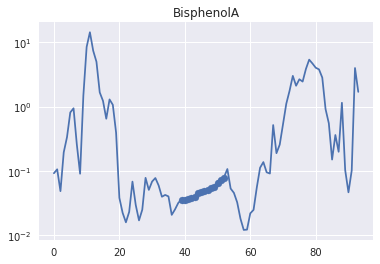

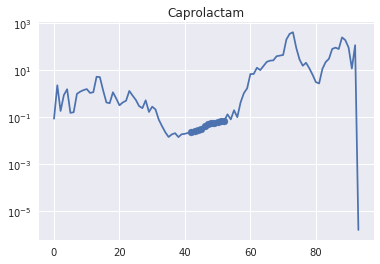

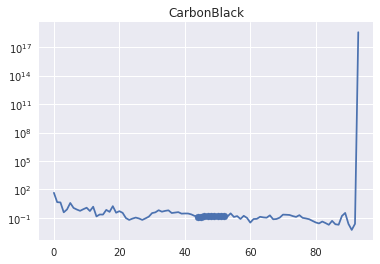

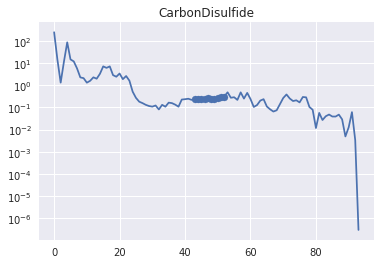

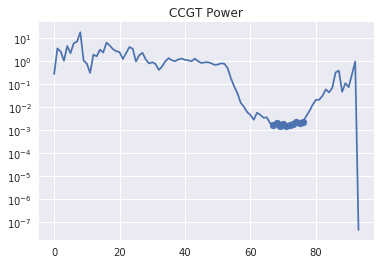

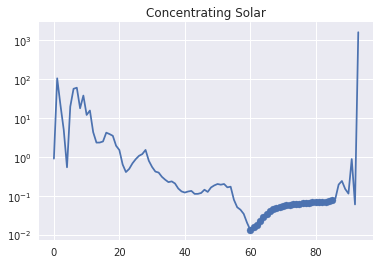

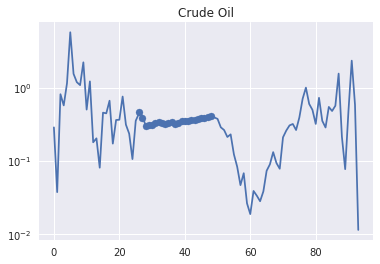

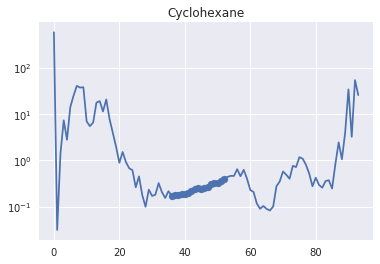

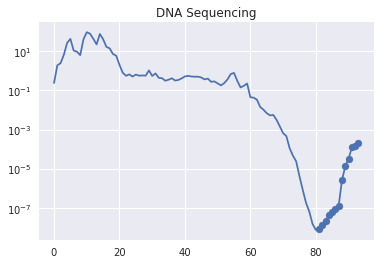

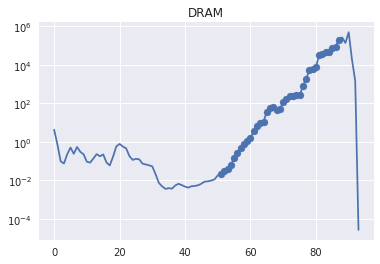

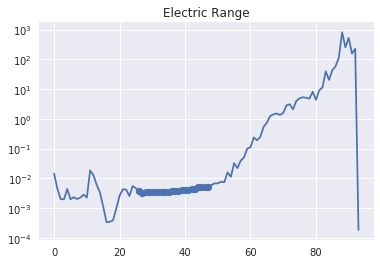

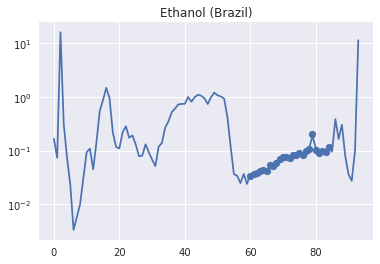

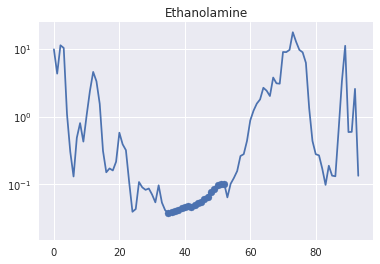

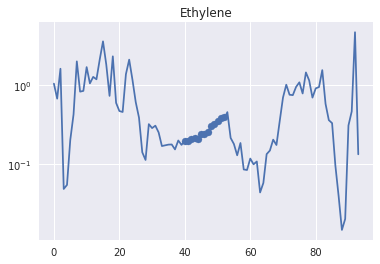

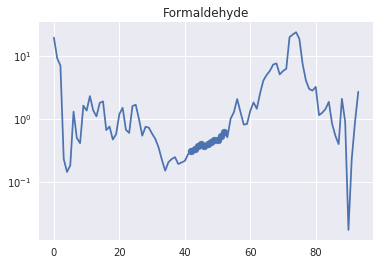

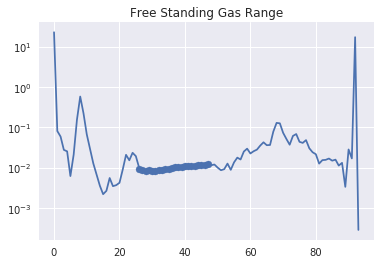

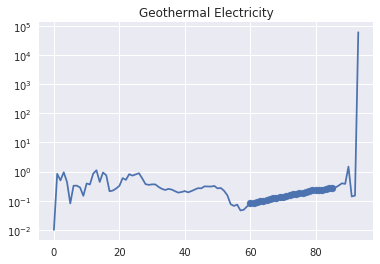

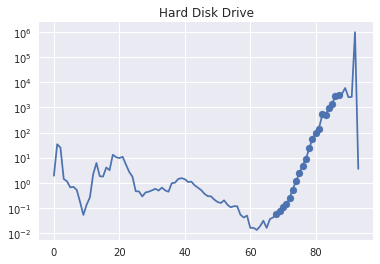

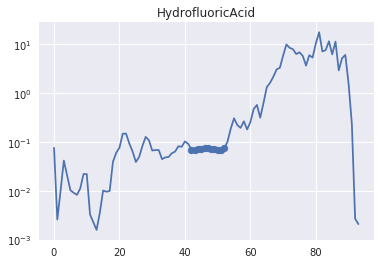

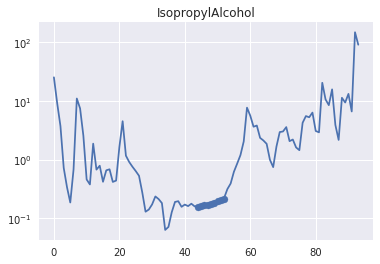

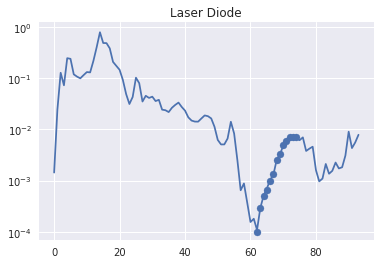

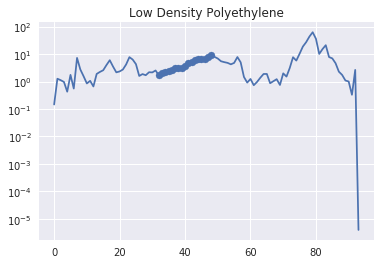

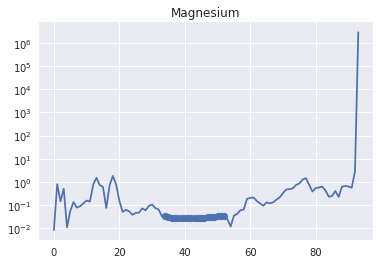

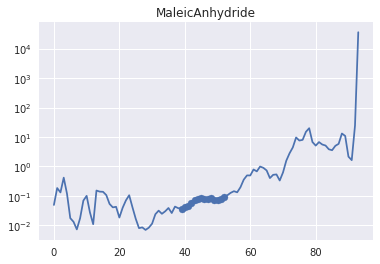

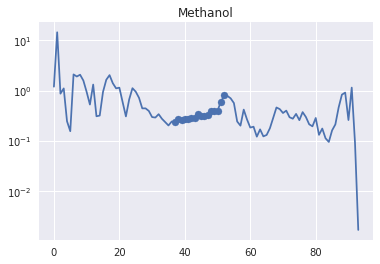

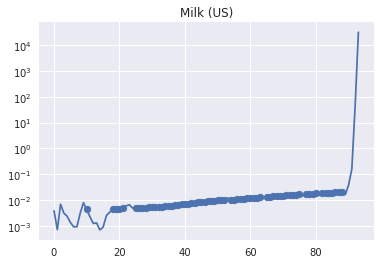

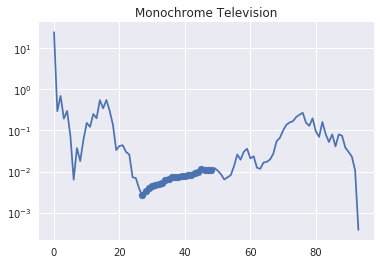

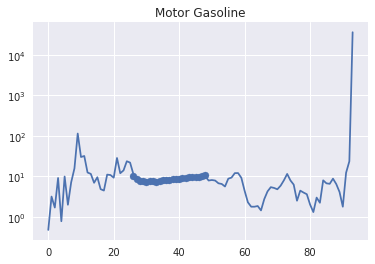

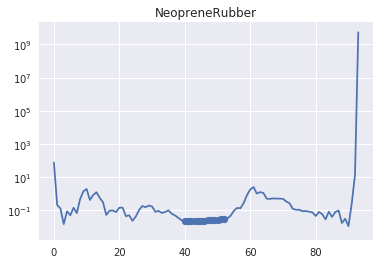

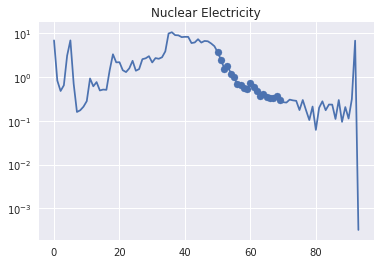

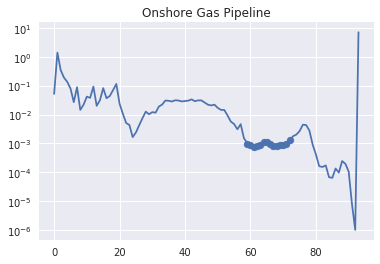

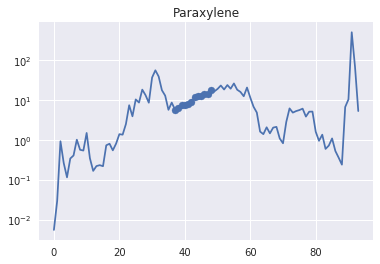

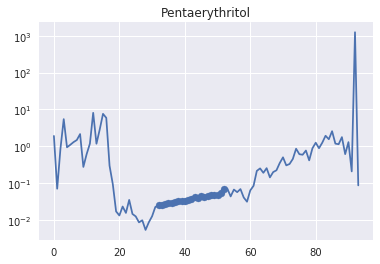

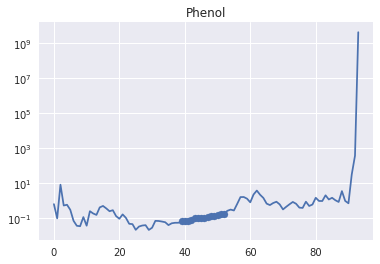

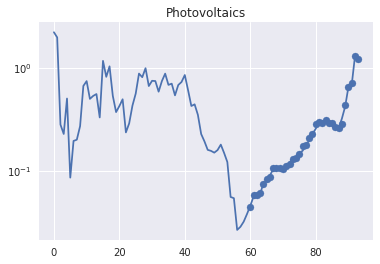

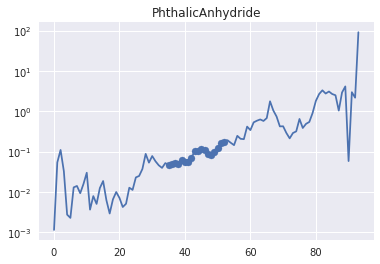

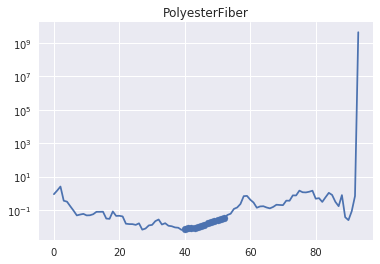

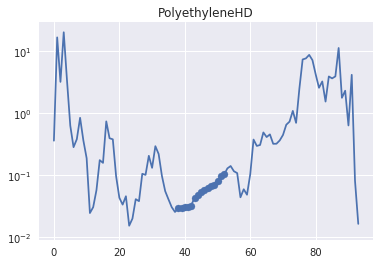

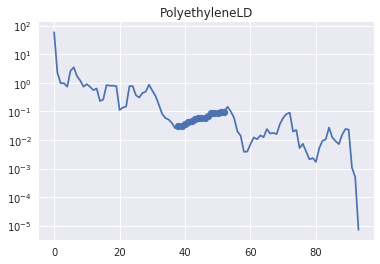

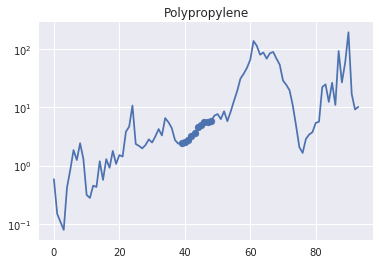

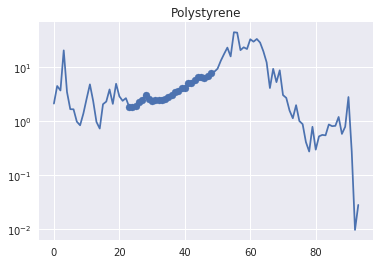

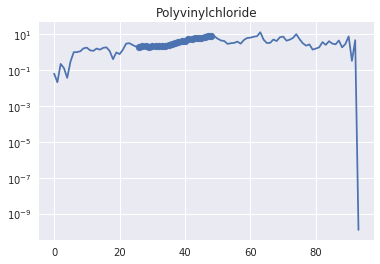

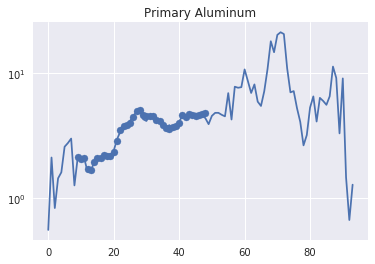

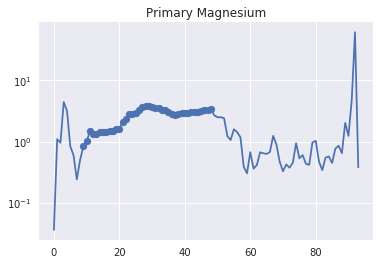

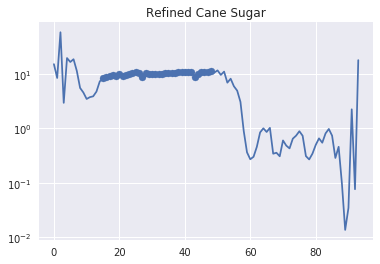

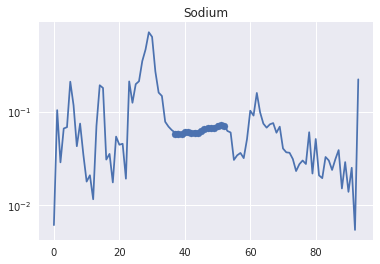

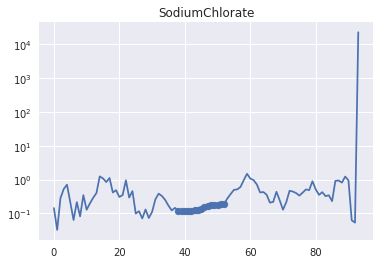

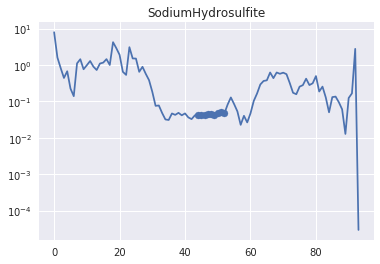

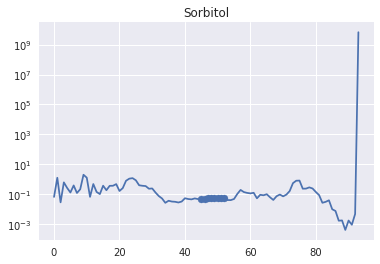

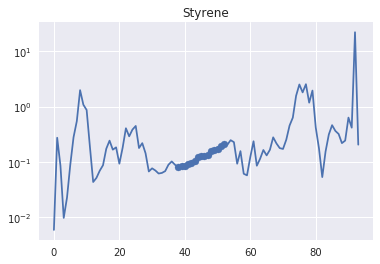

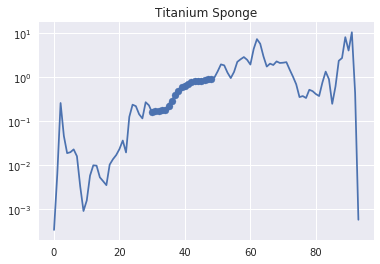

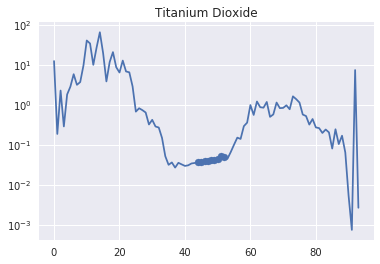

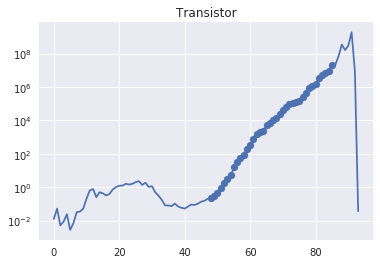

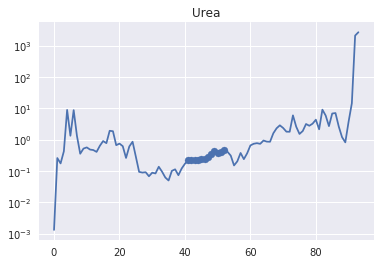

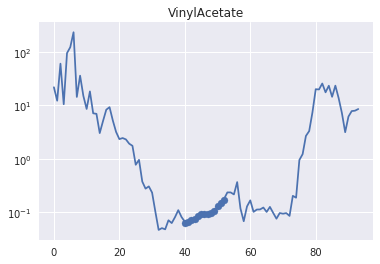

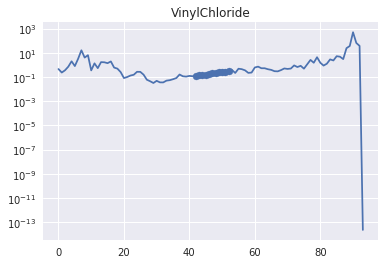

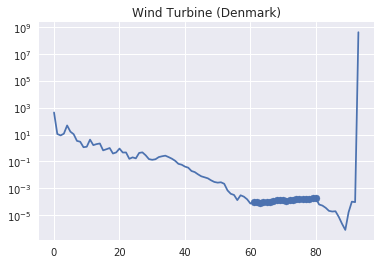

In [194]:
### Without horseshoe
for i in arange(Y.shape[1]):
    figure()
    scatter(range(Y.shape[0]), exp(Y.values[:,i]))
    plot(exp(q[:,i]))
    title(Y.columns[i])
    yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


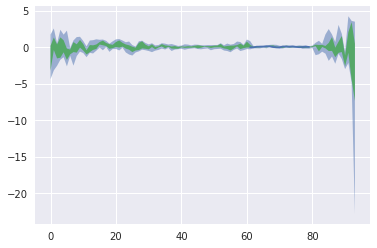

In [138]:
plot(Y.values[1:,i])
plot_time_series_inference(model_fit,ind=i)

KeyboardInterrupt: 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


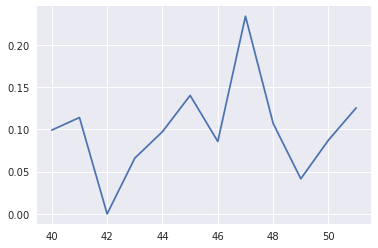

In [133]:
for i in arange(Y.shape[1]):
    figure()
    plot(Y.values[1:,i])
    plot_time_series_inference(model_fit,ind=i)
    title(i)